In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

Duplicate key in file PosixPath('/home/tudorjnu/.miniconda3/envs/main/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/dark.mplstyle'), line 20 ('grid.color:                          d1d1d1')


In [2]:
from sb3.utils import process_transitions

transitions_path = Path.cwd() / 'expert' / 'trial_2'
transitions = process_transitions(transitions_path)

/home/tudorjnu/.miniconda3/envs/main/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing:  /home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/expert/trial_2/episode_11
Processing:  /home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/expert/trial_2/episode_26
Processing:  /home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/expert/trial_2/episode_00
Processing:  /home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/expert/trial_2/episode_02
Processing:  /home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/expert/trial_2/episode_14
Processing:  /home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/expert/trial_2/episode_03
Processing:  /home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/expert/trial_2/episode_22
Processing:  /home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/expert/trial_2/episode_19
Processing:  /home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/expert/trial_2/episode_10
Processing:  /home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/expert/trial_2/episode_21
Processing:  /home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/expert/trial_2/episode_17

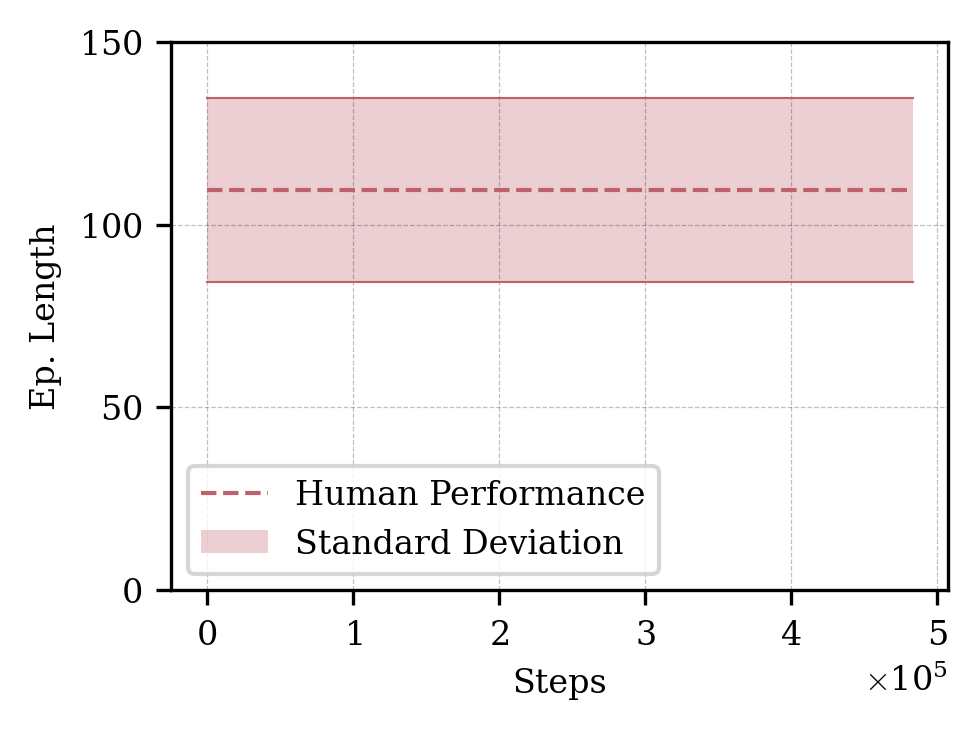

In [38]:
# Generate some data
time_steps = 500_000
n_ticks = 30
x = np.arange(0, time_steps, time_steps/n_ticks)
# make the same value appear in all 30 ticks
y = np.full(n_ticks, 109.45)
y_std = 25.16

# Plot the line, make it dashed
plt.plot(x, y, label='Human Performance', linestyle='--')

# Fill the area between the line and +- y_std
plt.fill_between(x, y - y_std, y + y_std, alpha=0.3, label='Standard Deviation')
# make two lines that contain the mean +- std
# make it the same color as the line above
plt.plot(x, y - y_std, color='C0', linewidth=0.5)
plt.plot(x, y + y_std, color='C0', linewidth=0.5)

# Add legend and labels
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Ep. Length')
# make y ticks from 50 to 300
plt.yticks(np.arange(0, 200, 50))
# use k not thousands for x ticks
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
# Show the plot
plt.show()

## Tensorboard Data

In [4]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
from pathlib import Path

In [10]:
# Path to the TensorBoard log directory


In [15]:
from tensorflow.python.summary.summary_iterator import summary_iterator

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [25]:
import os
import numpy as np
import pandas as pd

from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


def tabulate_events(dpath):
    summary_iterators = [EventAccumulator(os.path.join(dpath, dname)).Reload() for dname in os.listdir(dpath)]

    tags = summary_iterators[0].Tags()['scalars']
    print(tags)

    for it in summary_iterators:
        assert it.Tags()['scalars'] == tags

    out = defaultdict(list)
    steps = []

    for tag in tags:
        steps = [e.step for e in summary_iterators[0].Scalars(tag)]

        for events in zip(*[acc.Scalars(tag) for acc in summary_iterators]):
            assert len(set(e.step for e in events)) == 1

            out[tag].append([e.value for e in events])

    return out, steps


def to_csv(dpath):
    dirs = os.listdir(dpath)

    d, steps = tabulate_events(dpath)
    tags, values = zip(*d.items())
    np_values = np.array(values)

    for index, tag in enumerate(tags):
        df = pd.DataFrame(np_values[index], index=steps, columns=dirs)
        df.to_csv(get_file_path(dpath, tag))


def get_file_path(dpath, tag):
    file_name = tag.replace("/", "_") + '.csv'
    folder_path = os.path.join(dpath, 'csv')
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    return os.path.join(folder_path, file_name)



path = Path.cwd() / 'sb3' / 'experiments' / 'barkla' / 'logs' 
to_csv(path)

['rollout/ep_len_mean', 'rollout/ep_rew_mean', 'time/fps', 'train/actor_loss', 'train/critic_loss', 'train/ent_coef', 'train/ent_coef_loss', 'train/learning_rate']


AssertionError: 

Converting run eval- Not scalers to write


UnboundLocalError: local variable 'df' referenced before assignment